In [1]:
import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive, SVI, Trace_ELBO, TraceGraph_ELBO
from pyro.optim import Adam
from pyro import poutine

from gpytorch.kernels import RBFKernel, ScaleKernel
import gpytorch.distributions as gdist
import gpytorch as gp

import matplotlib.pyplot as plt
import matplotlib
import graphviz
import pdb
from pmextract import extract

## Bayesian Library Learning

We are given timeseries observations $x_i^t$, where the subscript $i$ indicates a random variable and superscript $t$ indicates a discrete time step. We want to find a small set of stochastic functions $f_1, f_2, \dotsc$ such that each $x_i^t$ is the result of applying some $f_j$ to variables $X_k^l$, where $l < t$. 

We can approach the problem using Bayesian nonparametrics, and assume that the function generating each variable is sampled from a Dirichlet process prior. Let $z_i^t$ be the index of the function that generates observation $x_i^t$. Our model can be summarized as follows:

$$
\begin{align*}
z_i^t &\sim \text{Dirichlet Process}(\gamma) \\
\theta_{z_i^t} &\sim \text{Dirichlet}(1, 1, \dotsc) \\ 
a_i^t(n) &\sim \text{Dirichlet Process}(\alpha) \\
b_i^t &\sim \text{Categorical}(\theta_{z_i^t}) \\
f_n &\sim \text{Gaussian Process}(\mu, \Sigma) \\ 
x_i^t &\sim f_{z_i^t}\left(x_{b_i^t(1)}^{a_i^t(1)}, x_{b_i^t(2)}^{a_i^t(2)}, \dotsc\right)
\end{align*}
$$

In [2]:
G = 3 # max number of functions in variational posterior
A = 2 # max number of arguments per function
γ = 1.0 # concentration parameter for function DP
α = 1.0 # concentration parameter for how old your args should be

In [3]:
def mix_weights(beta):
    "Turn iid Beta samples into the weights of a categorical (Stick Breaking DP)"
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

Time weights should be a diagonal matrix. 
Can we make constraints like that?

In [4]:
def model(T, M):
    "Sample a Yisong process for T timesteps and M variables"
    N = (T-1) * M
    with pyro.plate("Beta", G-1):
        beta = pyro.sample("beta", dist.Beta(1, γ))
    obs = pyro.plate("obs", N, dim=-1)
    with obs:
        z = pyro.sample("z", dist.Categorical(mix_weights(beta).unsqueeze(-2)))
    with pyro.plate("Beta2", T - 2):
        arg_beta = pyro.sample("beta2", dist.Beta(1, α))
    with pyro.plate("functions", G):
        θ = pyro.sample("θ", dist.Dirichlet(torch.ones(M)))
    time_stack = [F.pad(mix_weights(arg_beta[..., :i]), (0, T - i - 1)) for i in range(T-1)]
    time_weights = torch.stack(time_stack, dim=-2)
    with obs as varindex:
        t = varindex.div(M, rounding_mode='trunc')
        with pyro.plate("nth_arg", A):
            full_time_weights = time_weights[...,t,:]
            # 21(batch) x 1(arg) x 18(obs) x 3(time options)
            a = pyro.sample("a", dist.Categorical(full_time_weights))
            expanded_z = z.unsqueeze(-1).expand((*z.shape, M))
            var_weights = θ.gather(-2, expanded_z)
            b = pyro.sample("b", dist.Categorical(var_weights))
        return z, a, b

## Function Definitions

The choice of functions $f_i$ is arbitrary. Here, I experiment with using Gaussian Processes, but it would be easy to substiute neural nets or contingency tables. Neural nets have been used as leaf nodes in mixture models with VMP inference; I'm not sure if Pyro's ADVI would work quite as well. GPs seem like an easier starting point. 

In [5]:
class GPKernel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.kernel = ScaleKernel(RBFKernel())
    def forward(self, *args):
        return self.kernel(*args)

In [6]:
kernel = GPKernel()

## Yisong Process Likelihood

In [7]:
def likelihood(data):
    pyro.module("kernel", kernel)
    T, M = data.shape # timesteps by variables
    z, a, b = model(T, M)
    gp_in = data[a, b].transpose(-1, -2)
    gp_out = data[:-1].view(-1).unsqueeze(-2).unsqueeze(-2).unsqueeze(-2)
    k_xx = kernel(gp_in).add_diag(torch.tensor(0.1))
    mu = pyro.param("mu", lambda: torch.randn(G))
    gp = gdist.MultivariateNormal(mu[z].unsqueeze(-2), k_xx.unsqueeze(-3).unsqueeze(-3))
    pyro.sample(f"data", gp, obs=gp_out.expand(gp.shape()))

## Generate Fake Function Data

This class allows us to construct the function values one at a time. 
TODO: optimize this

In [8]:
class IncrementalGP:
    def __init__(self):
        self.samples = []
        self.inputs = []
        self.k_xx = None
        self.diag = gp.lazy.DiagLazyTensor(torch.ones(1))
        self.orig_mean = torch.randn(1) * 2
        
    def sample(self, s):
        if self.k_xx is None:
            sample = torch.randn(1)
            self.k_xx = self.diag
        else:
            k_sx = kernel(s.unsqueeze(0), torch.stack(self.inputs))
            covar = 1.0 - self.k_xx.inv_quad(k_sx[0])
            mean = self.orig_mean + k_sx @ self.k_xx.inv_matmul(torch.tensor(self.samples))
            sample = (mean + torch.randn(1) * covar).detach()
            self.k_xx = self.k_xx.cat_rows(k_sx, self.diag)
        self.samples.append(sample)
        self.inputs.append(s)
        return sample

### Example

In [13]:
igp = IncrementalGP()

In [19]:
samples = torch.cat([igp.sample(torch.tensor(i/10).float()) for i in range(40)])

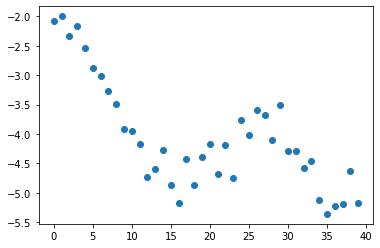

In [20]:
plt.scatter(torch.arange(40), samples)

## Generate Fake Yisong Process Data

In [9]:
def generate_data(T, M):
    from_function, arg_times, arg_vars = model(T, M)
    num_funcs = from_function.max() + 1
    funcs = [IncrementalGP() for _ in range(num_funcs)]
    generated = [torch.randn(M)]
    for t in range(T-1):
        built = []
        for v in range(M):
            n = T*t + v
            f = funcs[from_function[n]]
            args = [generated[arg_times[i][n]][arg_vars[i][n]]
                    for i in range(A)]
            built.append(f.sample(torch.tensor(args)))            
        generated.append(torch.tensor(built))
    return torch.stack(generated), {
        'num_funcs': num_funcs,
        'from_function': from_function,
        'arg_times': arg_times,
        'arg_vars': arg_vars,
        'T': T,
        'M': M}

In [10]:
data, params = generate_data(3, 9)

## Plot Generated Factor Graphs

Here's a sample from a Yisong Process. Different colors indicate different calls to a function. 

In [22]:
cmap = matplotlib.cm.get_cmap('seismic', len(params['from_function']))
colors = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

In [23]:
def plot_yisong_process(params):
    dot = graphviz.Digraph(engine='fdp', format='svg')
    with dot.subgraph(name='cluster_x') as c:
        for m in range(params['M']):
            for t in range(params['T']):
                c.node(f"X_{m}^{t}", pos=f"{m},{-t}!", label=f"<X<sub>{m}</sub><sup>{t}</sup>>")
    for n, f in enumerate(params['from_function']):
        c = colors[n]
        i = n % params['M']
        t = n // params['M']
        dot.edge(f"f{f}", f"X_{i}^{t+1}", color=c)
        for k in range(A):
            dot.edge(f"X_{params['arg_vars'][k, n]}^{params['arg_times'][k, n]}", f"f{f}", color=c)
    return dot

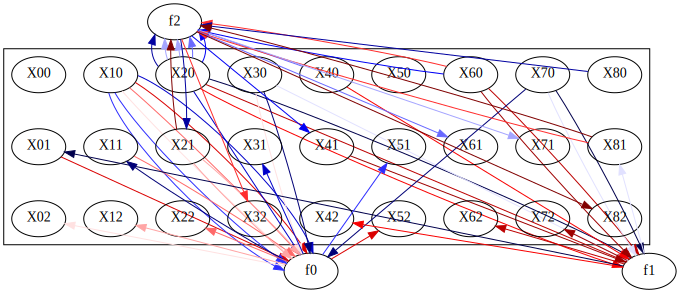

In [24]:
plot_yisong_process(params)

## Causality

Inference on a Yisong Process will produce a posterior over possible model structures that could have produced the given observations. We can use this posterior to ask questions about whether one variable "causes" another.

One way to interpret the question "Does $A$ cause $B$?" is "Is there a directed path between $A$ and $B$ in the true model?". We can represent this random indicator variable, called the *causal effect*, as $Q$. 

A more conventional interpretation of the question is "Would setting the variable $A$ to $c$ lead us to observe different values of $B$?" Specifically, assuming we observe $N$ samples of variable $B$, we let the causal effect $Q = \frac{1}{N}\sum_{i=1}^N B_i - B_i'$, where $B'$ is the variable given the intervention.

To find a posterior on $Q$, we can sample structures from the Yisong Process posterior and compute the value of $Q$ on each sample. If these samples are concentrated around $0$, we can be confident that there's no causal link. If the posterior is concentrated at a higher value, we can be confident that a causal link exits. But if we get a diffuse prior, we know that we need more data before we can make any kind of conclusion. 

## Variational Inference

I think hand tuned RJMH with proposal distributions informed by the progam synthesis world will work better than variational inference. But here's a baseline.

In [12]:
def guide(data):  
    T, M = data.shape
    N = (T-1) * M
    gamma_post = pyro.param('γ_post', lambda: dist.Uniform(0, 2).sample([G-1]), constraint=constraints.positive)
    alpha_post = pyro.param('α_post', lambda: dist.Uniform(0, 2).sample([T-2]), constraint=constraints.positive)
    z_prior = pyro.param('z_prior', lambda: dist.Dirichlet(torch.ones(G)).sample([N]), constraint=constraints.simplex)
    
    ts = [pyro.param(f"ts{i}", lambda: dist.Dirichlet(torch.ones(i+1)).sample([A, M]), constraint=constraints.simplex) for i in range(T-1)]
    time_stack = [F.pad(ts[i], (0, T - i - 1)) for i in range(T-1)]
    time_weights = torch.stack(time_stack, dim=-2).view(A, N, T)

    theta_post = pyro.param('theta_prior',
      lambda: dist.Dirichlet(torch.ones(M)).sample([G]), constraint=constraints.simplex)
    arg_weights = pyro.param('arg_weights',
      lambda: dist.Dirichlet(torch.ones(M)).sample([A, N]), constraint=constraints.simplex)
    
    with pyro.plate("Beta", G-1):
        beta = pyro.sample("beta", dist.Beta(1, gamma_post))
    obs = pyro.plate("obs", N, dim=-1)
    with obs:
        z = pyro.sample("z", dist.Categorical(z_prior))
    with pyro.plate("Beta2", T - 2):
        arg_beta = pyro.sample("beta2", dist.Beta(1, alpha_post))
    with pyro.plate("functions", G):
        θ = pyro.sample("θ", dist.Delta(theta_post).to_event(1))
    with obs:
        with pyro.plate("nth_arg", A):
            pyro.sample("a", dist.Categorical(time_weights))
            pyro.sample("b", dist.Categorical(arg_weights))

In [ ]:
pyro.clear_param_store()
elbo = Trace_ELBO(num_particles=100, vectorize_particles=True, max_plate_nesting=2)
optimizer = Adam({"lr": 1e-3, "betas": (0.90, 0.999)})
svi = SVI(likelihood, guide, optimizer, loss=elbo)
for epoch in range(80):
    loss = svi.step(data)
    print(loss)

## Extensions

- Perhaps the argument-time distributions should be separate for each function, rather than shared
- Perhaps we should limit the number of time-steps back we can draw function arguments from

## Applications

- Cell development? Say we look at single cell RNA sequencing data over the course of cell differentiation. We see what genes are being expressed at each point in time. The 'functions' we find will show how genes interact to inhibit or accelerate the expression of other genes. The problem with this is that there may not be much to be gained from it being non-Markovian. The non-Markovian assumption really means that there's some latent variable that gets influenced in a previous timestep by something we can observe. But with SSRNAseq, we observe everything. So this technique might be unnecessarily complicated. But perhaps we do it at a coarser level: the presence or absence of certain key signifiers in the observed mRNA at each step. Doing inference with ALL the data would probably be intractable anyway, so focusing on a coarsening would make sense.

- Language models? This thing feels an awful lot like a transformer, so we might take inspiration from the nlp world. What if the variables at each step are the vector embeddings of a word, and time is the order of words? Here, we'd allow the variable at time $t$ to draw from variables at times $<t$ and $>t$. The results might be nicely interpretable. 

- Patient records? Say we observe patient data over time. We might be able to derive causal relationships about how medical conditions develop over time. This data would likely be extremely sparse, so gaussian processes wouldn't be a great fit; you can't find distances between points with unknown coordinates. Contingency tables, on the other hand, would make it easy to marginalize over missing observations. 